In [2]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
HUMAN_EXPERIMENT = "eye_v10"  # batch 1 and batch 2 and batch 3 and batch 4
MACHINE_EXPERIMENT = "exp_v10"  # CodeGen (3 tries)
COMPARISON_FOLDER = "cmp_v05"
OUT_PAPER_FOLDER = "../data/paper_figures"

RELEVANT_LAYER_keywords = [
    "_rollout_condensed_all",
    "_rollout_last_layer",
    "_rollout_first_layer",
    "_rollout_last_half_summed",
    "_rollout_first_half_summed",
]

# CodeGen

In [5]:
# LOAD COMPARISON DATA
PATH_COMPARISON_FOLDER = f'../data/comparisons/{COMPARISON_FOLDER}/'
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)
print(f"Available comparisons: {available_comparisons}")
available_comparisons = [
    x for x in available_comparisons 
    if any([x.endswith(rel_key + ".csv") for rel_key in RELEVANT_LAYER_keywords])]
dfs = []
for comparison in tqdm(available_comparisons):
    df = pd.read_csv(os.path.join(PATH_COMPARISON_FOLDER, comparison))
    dfs.append(df)
DF = pd.concat(dfs)
DF["comparison_name"].unique()

Available comparisons: ['tl_spearman_humans.csv', 'tl_spearman_followup_max_50_all_layers.csv', 'plain_weights_humans.csv', 'plain_weights_meanfollowers.csv', 'tl_mse_copycat.csv', 'tl_mse_followup.csv', 'tl_mse_humans.csv', 'tl_mse_naivemax.csv', 'tl_mse_uniform.csv', 'tl_rank_copycat.csv', 'tl_rank_followup.csv', 'tl_rank_followup_fst_half.csv', 'tl_rank_followup_fst_layer.csv', 'tl_rank_followup_lst_half.csv', 'tl_rank_followup_lst_layer.csv', 'tl_rank_humans.csv', 'tl_rank_naivemax.csv', 'tl_rank_uniform.csv', 'tl_spearman_copycat.csv', 'tl_spearman_followup.csv', 'tl_spearman_followup_fst_half.csv', 'tl_spearman_followup_fst_layer.csv', 'tl_spearman_followup_lst_half.csv', 'tl_spearman_followup_lst_layer.csv', 'tl_spearman_followup_max_10_all_layers.csv', 'tl_spearman_naivemax.csv', 'tl_spearman_rollout_condensed_all.csv', 'tl_spearman_rollout_first_half_summed.csv', 'tl_spearman_rollout_first_layer.csv', 'tl_spearman_rollout_last_half_summed.csv', 'tl_spearman_rollout_last_layer.

100%|██████████| 10/10 [00:57<00:00,  5.73s/it]


array(['tl_spearman_rollout_condensed_all',
       'tl_spearman_rollout_first_half_summed',
       'tl_spearman_rollout_first_layer',
       'tl_spearman_rollout_last_half_summed',
       'tl_spearman_rollout_last_layer', 'tl_top3_rollout_condensed_all',
       'tl_top3_rollout_first_half_summed', 'tl_top3_rollout_first_layer',
       'tl_top3_rollout_last_half_summed', 'tl_top3_rollout_last_layer'],
      dtype=object)

# Spearman

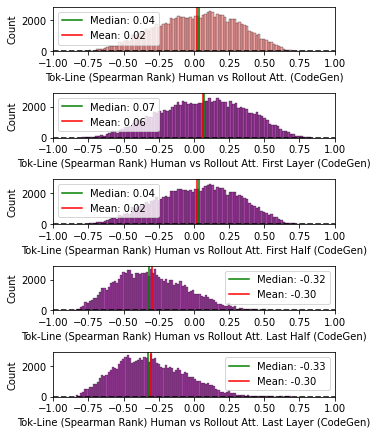

In [6]:
matrix_comparisons = [   
    {
        "long": "Human vs Rollout Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_rollout_condensed_all") & 
            (DF["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
    {
        "long": "Human vs Rollout Att. First Layer (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_rollout_first_layer") &
            (DF["spearman_res.corr"] != -1)],
        "color": 'purple',
    },
    {
        "long": "Human vs Rollout Att. First Half (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_rollout_first_half_summed") &
            (DF["spearman_res.corr"] != -1)],
        "color": 'purple',
    },
    {
        "long": "Human vs Rollout Att. Last Half (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_rollout_last_half_summed") &
            (DF["spearman_res.corr"] != -1)],
        "color": 'purple',
    },
    {
        "long": "Human vs Rollout Att. Last Layer (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_rollout_last_layer") &
            (DF["spearman_res.corr"] != -1)],
        "color": 'purple',
    },
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Tok-Line (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "abl_study_tl_rank.pdf"),
)

## Top-3

/tmp/ipykernel_2877619/244144709.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


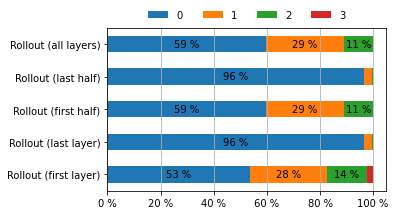

In [7]:
comparisons = [
    {
        "key": "tl_top3_rollout_first_layer",
        "name": "Rollout (first layer)",
    },
    {
        "key": "tl_top3_rollout_last_layer",
        "name": "Rollout (last layer)",
    },
    {
        "key": "tl_top3_rollout_first_half_summed",
        "name": "Rollout (first half)",
    },
    {
        "key": "tl_top3_rollout_last_half_summed",
        "name": "Rollout (last half)",
    },
    {
        "key": "tl_top3_rollout_condensed_all",
        "name": "Rollout (all layers)",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = DF[DF["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4
)
ax.set_ylabel(None) 
fig.set_size_inches(5, 3)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "abl_study_rollout_tl_top3.pdf"), bbox_inches='tight')